<a href="https://colab.research.google.com/github/Nefarian1/STQD6324-Data-Management-work/blob/main/Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STQD6324 Assignment 4 PANZHANGYU P136922

Using the u.user file from the MovieLens 100k Dataset (ml-100k.zip), which can be
downloaded from https://grouplens.org/datasets/movielens/, write a python script that acts
as a wrapper function to execute Cassandra Query Language (CQL) and Spark2 Structured
Query Language (SQL) in order to answer the following questions [display only the top ten
results for each question]:
+ i) Calculate the average rating for each movie.
+ ii) Identify the top ten movies with the highest average ratings.
+ iii) Find the users who have rated at least 50 movies and identify their favourite movie
genres.
+ iv) Find all the users with age that is less than 20 years old.
+ v) Find all the users who have the occupation “scientist” and their age is between 30 and
40 years old.

Your python script should include the following elements:
1. Python libraries used to execute Spark2 and Cassandra sessions.
2. Functions to parse the u.user file into HDFS.
3. Functions to load, read, and create Resilient Distributed Dataset (RDD) objects.
4. Functions to convert the RDD objects into DataFrame.
5. Functions to write the DataFrame into the Keyspace database created in Cassandra.
6. Functions to read the table back from Cassandra into a new DataFrame.

#<font color='red'>My Files Location🤓🤓🤓
The files I need are all in the Github homepage. Here is the corresponding link: https://github.com/Nefarian1/STQD6324-Data-Management-work/tree/f3a92d8eeece0d841ab4d4774089838ba0eda83e/assignment4

<font color='red'>assignment4_pzy_code.txt

# Introduce
+ u.data     -- The full u data set, 100000 ratings by 943 users on 1682 items.
              Each user has rated at least 20 movies.  Users and items are
              numbered consecutively from 1.  The data is randomly
              ordered. This is a tab separated list of
	         user id | item id | rating | timestamp.
              The time stamps are unix seconds since 1/1/1970 UTC   

+ u.info     -- The number of users, items, and ratings in the u data set.

+ u.item     -- Information about the items (movies); this is a tab separated
              list of
              movie id | movie title | release date | video release date |
              IMDb URL | unknown | Action | Adventure | Animation |
              Children's | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western |
              The last 19 fields are the genres, a 1 indicates the movie
              is of that genre, a 0 indicates it is not; movies can be in
              several genres at once.
              The movie ids are the ones used in the u.data data set.

+ u.genre    -- A list of the genres.

+ u.user     -- Demographic information about the users; this is a tab
              separated list of
              user id | age | gender | occupation | zip code
              The user ids are the ones used in the u.data data set.

+ u.occupation -- A list of the occupations.

# Prepare

cd ml-100k/

wget http://media.sundog-soft.com/hadoop/ml-100k/u.data

wget http://media.sundog-soft.com/hadoop/ml-100k/u.info

wget http://media.sundog-soft.com/hadoop/ml-100k/u.item

wget http://media.sundog-soft.com/hadoop/ml-100k/u.genre

wget http://media.sundog-soft.com/hadoop/ml-100k/u.user

wget http://media.sundog-soft.com/hadoop/ml-100k/u.occupation

ls

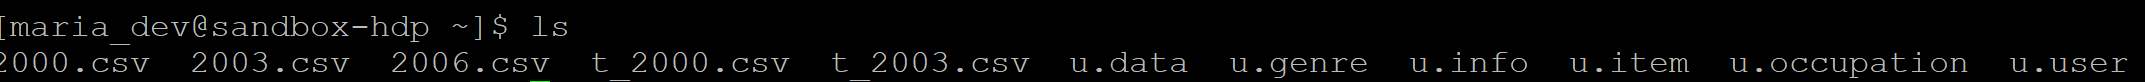

In [4]:
from IPython.display import Image
Image('/content/ls.png', width = 900)

cd ..

su root

 + hadoop (password) -> panzhangyu

sudo yum install python-pip

sudo pip install numpy==1.16

 + ESC

 :1,$d 清除 Clear

 i 插入模式 Insert Mode

# i Calculate the average rating for each movie

# i 计算每部电影的平均评分


vi oneSQL.py


-# -*- coding: utf-8 -*-

from pyspark.sql import SparkSession

from pyspark.sql import functions as F

def parseRating(line):

    fields = line.split('\t')
    return (int(fields[0]), int(fields[1]), float(fields[2]), int(fields[3]))

if __name__ == "__main__":
    # Creating a SparkSession
    spark = SparkSession.builder \
        .appName("AverageMovieRatings") \
        .getOrCreate()

    # 读取数据 Reading Data
    lines = spark.sparkContext.textFile("hdfs:///user/maria_dev/ml-100k/u.data")
    
    # 解析数据 Analytical data
    ratings = lines.map(parseRating)
    
    # Convert to DataFrame
    ratingsDF = ratings.toDF(["userID", "movieID", "rating", "timestamp"])
    
    # 计算每部电影的平均评分 Calculate the average rating for each movie
    avgRatings = ratingsDF.groupBy("movieID").agg(F.avg("rating").alias("avg_rating"))
    
    #
    avgRatings.show(10)
    
    #
    spark.stop()



spark-submit oneSQL.py

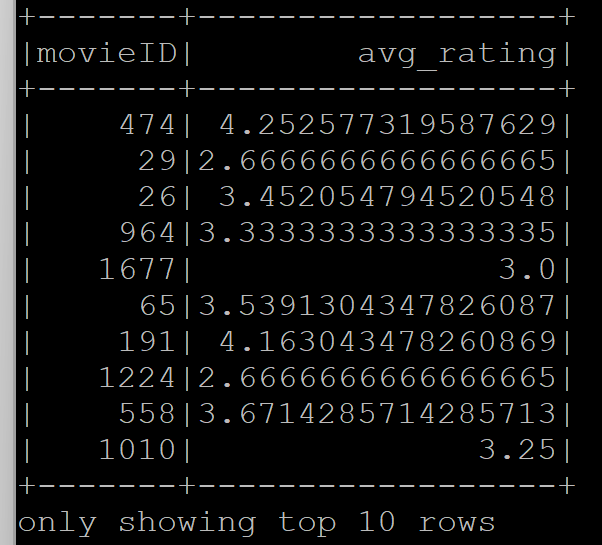

In [6]:
from IPython.display import Image
Image('/content/i.png', width = 400)

# ii Find the users who have rated at least 50 movies and their favorite movie genres

# ii 找出至少评价了50部电影的用户及其最喜欢的电影类型

vi twoSQL.py


-# -*- coding: utf-8 -*-

from pyspark.sql import SparkSession

from pyspark.sql import functions as F

from pyspark.sql.types import IntegerType

if __name__ == "__main__":
    # Creating a SparkSession
    spark = SparkSession.builder \
        .appName("TopTenMovies") \
        .getOrCreate()

    # 读取并解析电影评分数据 Read and parse movie ratings data
    ratings = spark.read.csv("hdfs:///user/maria_dev/ml-100k/u.data", sep="\t")
    # 指定列的数据类型为整数 Specifies that the data type of the column is an integer
    ratings = ratings.withColumnRenamed("_c0", "userID") \
                     .withColumnRenamed("_c1", "movieID") \
                     .withColumnRenamed("_c2", "rating") \
                     .withColumnRenamed("_c3", "timestamp")
    ratings = ratings.select("movieID", ratings["rating"].cast(IntegerType()))

    # 计算每部电影的平均评分并按降序排列 Calculate the average rating for each movie and sort them in descending order
    average_ratings = ratings.groupBy("movieID").avg("rating")
    top_ten_movies = average_ratings.orderBy(F.desc("avg(rating)")).limit(10)

    #
    top_ten_movies.show()

    #
    spark.stop()


spark-submit twoSQL.py

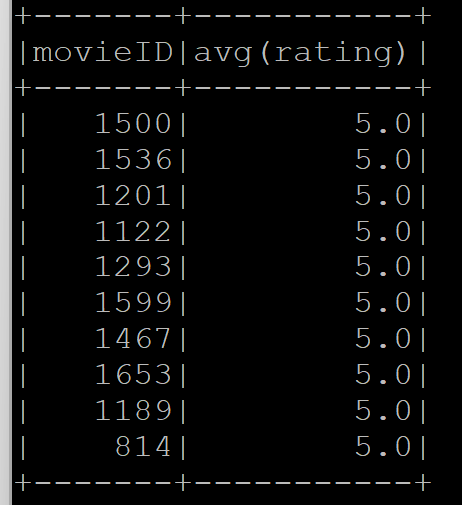

In [7]:
from IPython.display import Image
Image('/content/ii.png', width = 400)

# iii Find the users who have rated at least 50 movies and their favorite movie genres

# iii 找出至少评价了50部电影的用户及其最喜欢的电影类型

vi threeSQL.py


-# -*- coding: utf-8 -*-

from pyspark.sql import SparkSession

from pyspark.sql import functions as F

def parseUserRating(line):
    fields = line.split('\t')
    return (int(fields[0]), int(fields[1]), float(fields[2]))

def parseMovie(line):
    fields = line.split('|')
    genres = [int(genre) for genre in fields[5:]]
    return (int(fields[0]), genres)

if __name__ == "__main__":
    #
    spark = SparkSession.builder \
        .appName("FrequentRaters") \
        .getOrCreate()

    #
    lines = spark.sparkContext.textFile("hdfs:///user/maria_dev/ml-100k/u.data")
    userRatings = lines.map(parseUserRating)
    userRatingsDF = userRatings.toDF(["userID", "movieID", "rating"])

    #
    movieLines = spark.sparkContext.textFile("hdfs:///user/maria_dev/ml-100k/u.item")
    movies = movieLines.map(parseMovie)
    moviesDF = movies.toDF(["movieID", "genres"])

    #
    moviesDF = moviesDF.select("movieID", F.explode("genres").alias("genreIndex"))

    #
    genres = ["unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime",
              "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery",
              "Romance", "Sci-Fi", "Thriller", "War", "Western"]

    genreMapping = {i: genres[i] for i in range(len(genres))}

    # 筛选出至少对 50 部电影进行过评分的用户 Filter for users who have rated at least 50 movies
    userCounts = userRatingsDF.groupBy("userID").count().filter("count >= 50").select("userID")

    # 找出这些用户最喜欢的电影类型 Find out the most popular movie genres for these users
    userRatingsDF.createOrReplaceTempView("userRatings")
    moviesDF.createOrReplaceTempView("movies")
    userCounts.createOrReplaceTempView("activeUsers")

    frequentRaters = spark.sql("""
        SELECT u.userID, m.genreIndex, COUNT(*) AS genre_count
        FROM userRatings u
        JOIN activeUsers a ON u.userID = a.userID
        JOIN movies m ON u.movieID = m.movieID
        WHERE m.genreIndex = 1
        GROUP BY u.userID, m.genreIndex
        ORDER BY genre_count DESC
    """)

    # 将电影类型索引映射为类型名称 Map movie genre index to genre name
    frequentRaters = frequentRaters.withColumn("genre", F.udf(lambda index: genreMapping[index])(frequentRaters["genreIndex"]))

    #
    frequentRaters.select("userID", "genre", "genre_count").show(10)

    #
    spark.stop()


spark-submit threeSQL.py

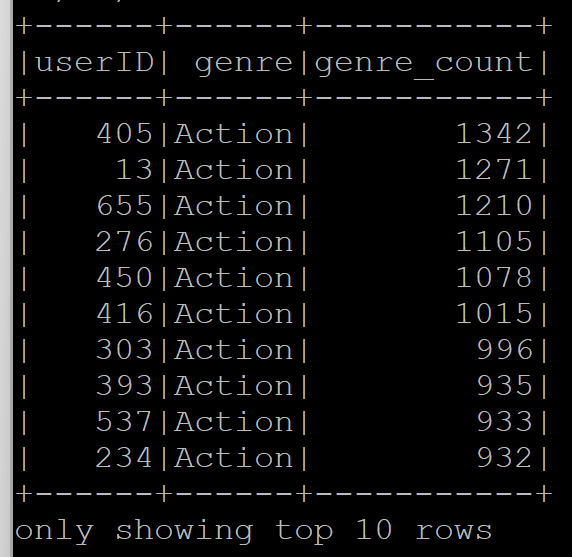

In [8]:
from IPython.display import Image
Image('/content/iii.png', width = 400)

# iv Find all users under 20 years old

# iv 找出所有小于20岁的用户

vi fourSQL.py


-# -*- coding: utf-8 -*-

from pyspark.sql import SparkSession

from pyspark.sql import Row

def parseUser(line):
    fields = line.split('|')
    return Row(userID=int(fields[0]), age=float(fields[1]), gender=fields[2], occupation=fields[3], zip=fields[4])

if __name__ == "__main__":
    # 创建一个SparkSession
    spark = SparkSession.builder \
    .appName("UsersUnder20") \
    .getOrCreate()
    
    #
    lines = spark.sparkContext.textFile("hdfs:///user/maria_dev/ml-100k/u.user")
    
    #
    users = lines.map(parseUser)
    
    # DataFrame
    userDataset = spark.createDataFrame(users)
    
    # 找出所有小于20岁的用户。 Find all users who are younger than 20 years old.
    usersUnder20 = userDataset.filter(userDataset.age < 20)
    
    #
    usersUnder20.show(10)
    
    #
    spark.stop()


spark-submit fourSQL.py

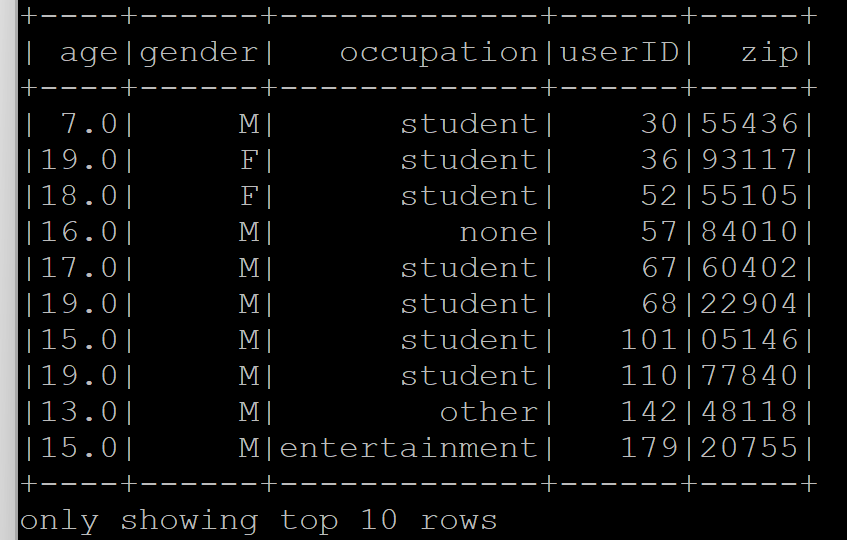

In [9]:
from IPython.display import Image
Image('/content/iv.png', width = 400)

# v Find users whose occupation is "scientist" and whose age is between 30 and 40

# v 找出职业是“scientist”，年龄在30到40岁之间的用户

vi fiveSQL.py


-# -*- coding: utf-8 -*-

from pyspark.sql import SparkSession

from pyspark.sql import functions as F

from collections import namedtuple

-# 定义命名元组 Defining a named tuple

User = namedtuple("User", ["userID", "age", "gender", "occupation", "zip"])


def parseUser(line):

    try:

        fields = line.split('|')
        return User(userID=int(fields[0]), age=int(fields[1]), gender=fields[2], occupation=fields[3], zip=fields[4])

    except:

        # If parsing fails, None is returned.  如果解析失败，则返回None
        return None

if __name__ == "__main__":
    #
    spark = SparkSession.builder \
        .appName("ScientistUsers") \
        .getOrCreate()

    # 读取并解析用户数据 Read and parse user data
    lines = spark.sparkContext.textFile("hdfs:///user/maria_dev/ml-100k/u.user")
    users = lines.map(parseUser).filter(lambda x: x is not None)
    # 定义列名 Define column names
    columns = ["userID", "age", "gender", "occupation", "zip"]
    # Convert named tuple to DataFrame. 将命名元组转换为DataFrame。
    usersDF = users.toDF(columns)
    
    # 找出职业是“scientist”，年龄在30到40岁之间的用户。 Find users whose occupation is "scientist" and whose age is between 30 and 40.
    scientists = usersDF.filter((usersDF.occupation == "scientist") & (usersDF.age.between(30, 40)))
    
    #
    scientists.show(10)
    
    #
    spark.stop()


spark-submit fiveSQL.py


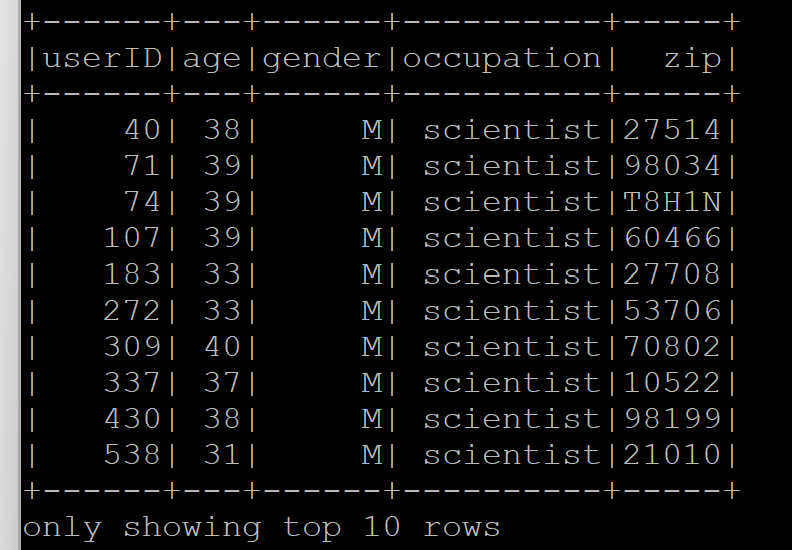

In [10]:
from IPython.display import Image
Image('/content/v.png', width = 400)